<a href="https://colab.research.google.com/github/AmirSamanMirjalili/ANN_based_Fault_Detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.io
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split




# Fault information with dates
faults = [
    {"Fault tag": "f18", "Sample Range": (58800, 59800), "Date": "October 30, 2001"},
    {"Fault tag": "f16", "Sample Range": (57275, 57550), "Date": "November 9, 2001"},
    {"Fault tag": "f18", "Sample Range": (58830, 58930), "Date": "November 9, 2001"},
    {"Fault tag": "f18", "Sample Range": (58520, 58625), "Date": "November 9, 2001"},
    {"Fault tag": "f18", "Sample Range": (54600, 54700), "Date": "November 17, 2001"},
    {"Fault tag": "f16", "Sample Range": (56670, 56770), "Date": "November 17, 2001"}
]


# Load the .mat file
data = scipy.io.loadmat('DATA.mat')

# Display the keys in the .mat file to identify the variable names
print(data.keys())

# Access the data for November 9 and November 17
data_nov9 = data['NOV9']
data_nov17 = data['NOV17']

# Convert to pandas DataFrames
df_nov9 = pd.DataFrame(data_nov9)
df_nov17 = pd.DataFrame(data_nov17)

# Assuming df_nov9 is your DataFrame
print(df_nov9.columns)

# Adjust the label_data function to directly use the row index
def label_data(row, faults, date):
    for fault in faults:
        if fault["Date"] == date:
            start, end = fault["Sample Range"]
            if start <= row <= end:  # Directly use the row value which is the sample index
                return fault["Fault tag"]
    return 'normal'

# Apply the function to the DataFrame
df_nov9['Fault'] = df_nov9[0].apply(lambda x: label_data(x, faults, "November 9, 2001"))
print(df_nov9.head())


# Encode labels
encoder = LabelEncoder()
df_nov9['Fault'] = encoder.fit_transform(df_nov9['Fault'])

# Normalize the data
scaler = StandardScaler()
features = df_nov9.columns.difference(['Fault'])
df_nov9[features] = scaler.fit_transform(df_nov9[features])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_nov9[features], df_nov9['Fault'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2  # 0.25 x 0.8 = 0.2

# Now X_train, X_val, X_test, y_train, y_val, y_test are ready to be used for model training and evaluation.

dict_keys(['__header__', '__version__', '__globals__', 'NOV17', 'NOV9'])
RangeIndex(start=0, stop=17, step=1)
     0      1      2     3      4     5     6     7      8      9    10    11  \
0  0.0  699.1  300.6  97.8  296.2  42.7  42.0  46.1  129.1  133.4  12.2  26.4   
1  1.0  697.7  298.9  97.8  295.4  41.8  41.6  45.3  129.1  133.3  12.2  26.4   
2  2.0  696.2  301.8  97.8  295.4  42.9  41.4  46.6  129.1  133.4  12.2  26.3   
3  3.0  702.8  300.9  97.7  295.1  43.1  41.5  46.0  129.1  133.4  12.2  26.2   
4  4.0  701.3  292.6  97.8  294.6  42.6  42.3  47.0  129.1  133.4  12.2  26.1   

     12     13     14     15     16   Fault  
0  53.0  242.0  136.9  164.0  132.1  normal  
1  51.6  241.4  136.9  164.1  132.1  normal  
2  50.3  241.6  136.9  164.1  132.1  normal  
3  50.2  241.6  136.9  164.2  132.1  normal  
4  51.8  241.3  136.8  163.9  132.1  normal  


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from scipy.fft import fft

# Assuming df_nov9 is already loaded and preprocessed

# Define a function to split and normalize data
def prepare_data(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Prepare target variable
y = df_nov9['Fault']

# 1. PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(df_nov9.drop('Fault', axis=1))
X_train_pca, X_val_pca, X_test_pca, y_train_pca, y_val_pca, y_test_pca = prepare_data(X_pca, y)

# 2. SelectKBest
skb = SelectKBest(score_func=f_classif, k=5)
X_skb = skb.fit_transform(df_nov9.drop('Fault', axis=1), y)
X_train_skb, X_val_skb, X_test_skb, y_train_skb, y_val_skb, y_test_skb = prepare_data(X_skb, y)

# 3. Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_nov9.drop('Fault', axis=1), y)
importances = rf.feature_importances_
indices_rf = np.argsort(importances)[-5:]  # Top 5 features
X_rf = df_nov9.iloc[:, indices_rf].values
X_train_rf, X_val_rf, X_test_rf, y_train_rf, y_val_rf, y_test_rf = prepare_data(X_rf, y)

# 4. Lasso for feature selection
lasso = Lasso(alpha=0.01)
lasso.fit(df_nov9.drop('Fault', axis=1), y)
lasso_coef = np.abs(lasso.coef_)
indices_lasso = np.argsort(lasso_coef)[-5:]  # Top 5 features
X_lasso = df_nov9.iloc[:, indices_lasso].values
X_train_lasso, X_val_lasso, X_test_lasso, y_train_lasso, y_val_lasso, y_test_lasso = prepare_data(X_lasso, y)

# 5. FFT
X_fft = np.abs(fft(df_nov9.drop('Fault', axis=1).values, axis=0))
X_fft = pd.DataFrame(X_fft[:, :5])  # Taking the first 5 FFT components
X_train_fft, X_val_fft, X_test_fft, y_train_fft, y_val_fft, y_test_fft = prepare_data(X_fft, y)

# Now you have training, validation, and test sets prepared for each feature selection method

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model configuration
input_dim = X_train.shape[1]  # Number of features
output_dim = len(np.unique(y_train))  # Number of classes
dropout_rate = 0.5  # Dropout rate

# Building the model
model = Sequential([
    Dense(128, input_dim=input_dim, activation='relu'),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(output_dim, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Model summary
model.summary()

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10755 (42.01 KB)
Trainable params: 10755 (42.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
1620/162

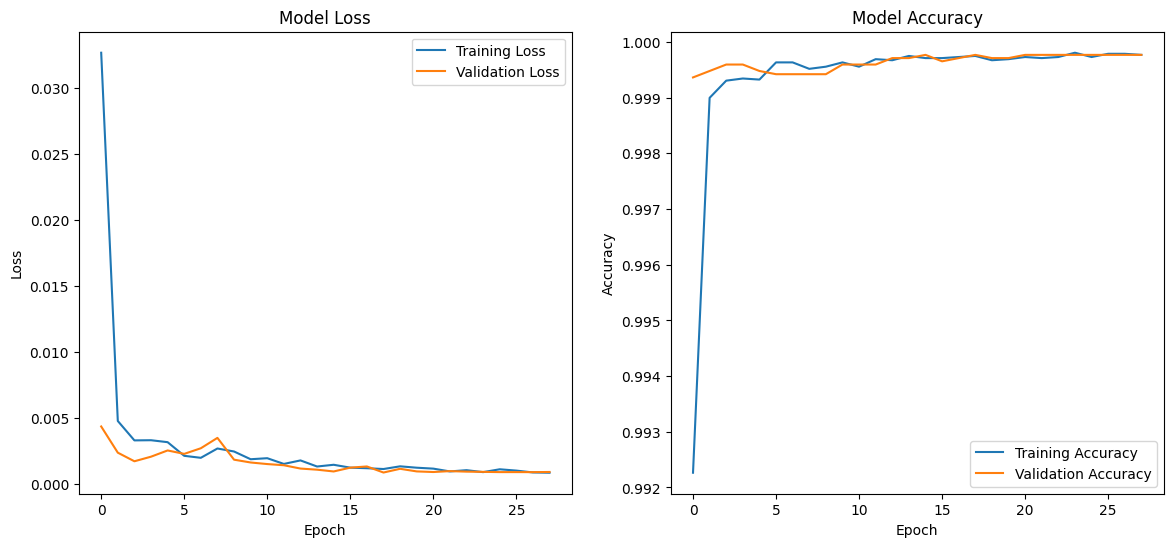

In [4]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Configuration for Model 1 (More layers)
model1 = Sequential([
    Dense(128, input_dim=input_dim, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(output_dim, activation='softmax')
])
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

# Configuration for Model 2 (Different optimizer)
model2 = Sequential([
    Dense(128, input_dim=input_dim, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(output_dim, activation='softmax')
])
model2.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

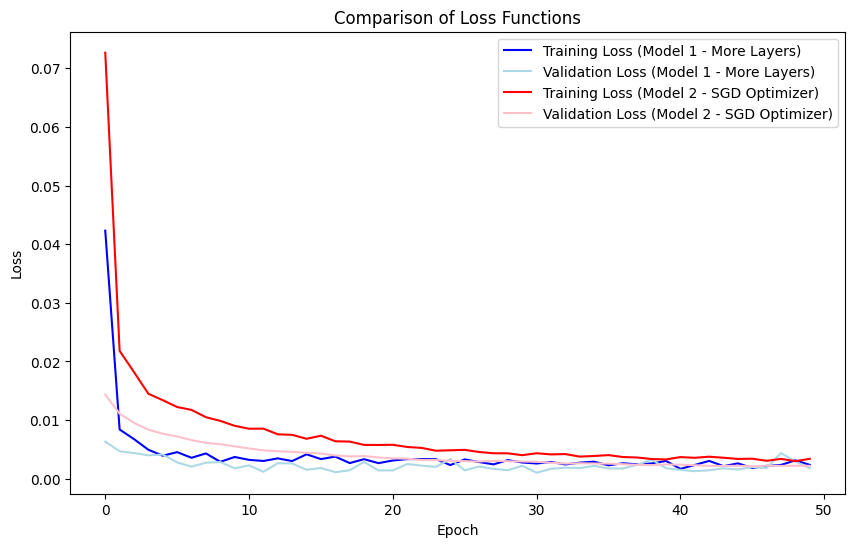

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history1.history['loss'], label='Training Loss (Model 1 - More Layers)', color='blue')
plt.plot(history1.history['val_loss'], label='Validation Loss (Model 1 - More Layers)', color='lightblue')
plt.plot(history2.history['loss'], label='Training Loss (Model 2 - SGD Optimizer)', color='red')
plt.plot(history2.history['val_loss'], label='Validation Loss (Model 2 - SGD Optimizer)', color='pink')
plt.title('Comparison of Loss Functions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

540/540 [==============================] - 3s 6ms/step


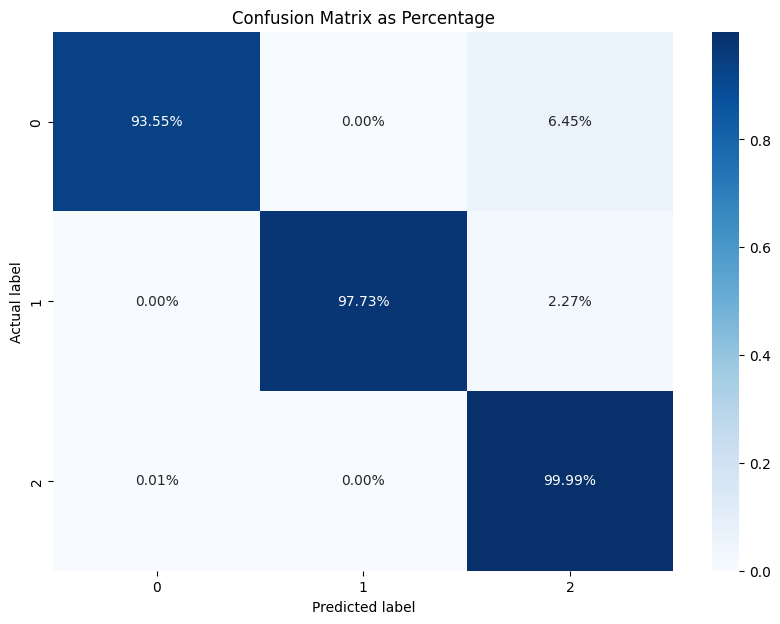

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        62
           1       1.00      0.98      0.99        44
           2       1.00      1.00      1.00     17174

    accuracy                           1.00     17280
   macro avg       0.99      0.97      0.98     17280
weighted avg       1.00      1.00      1.00     17280



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Assuming you have a trained model, and X_test, y_test ready
# Predict the classes using the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix to show percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues')
plt.title('Confusion Matrix as Percentage')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Generate and print the classification report
report = classification_report(y_test, y_pred_classes)
print(report)

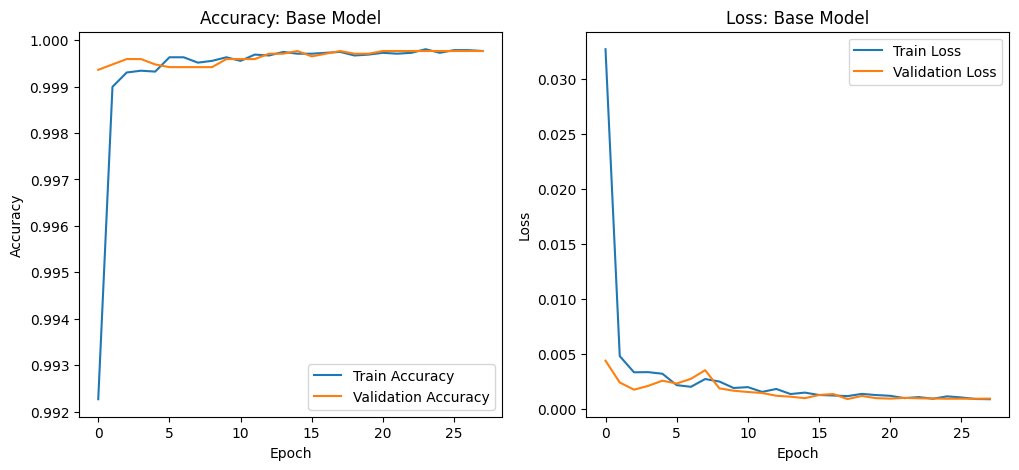

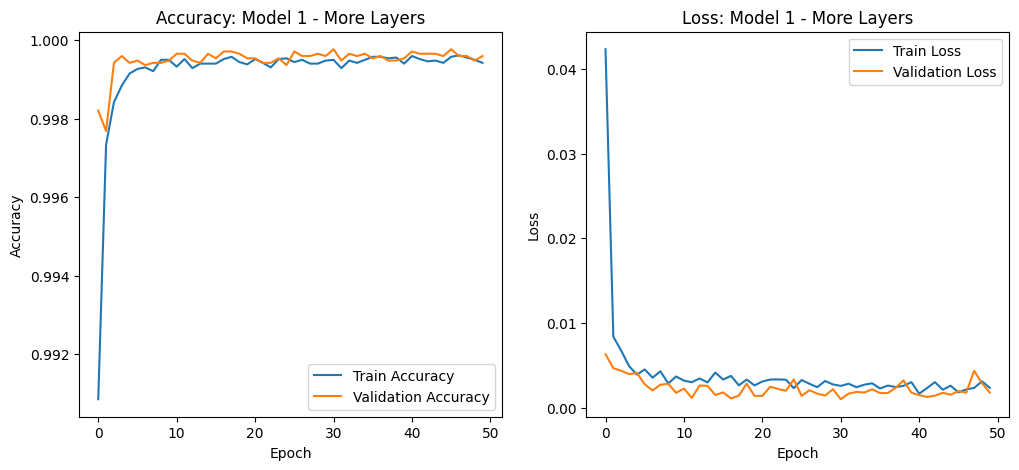

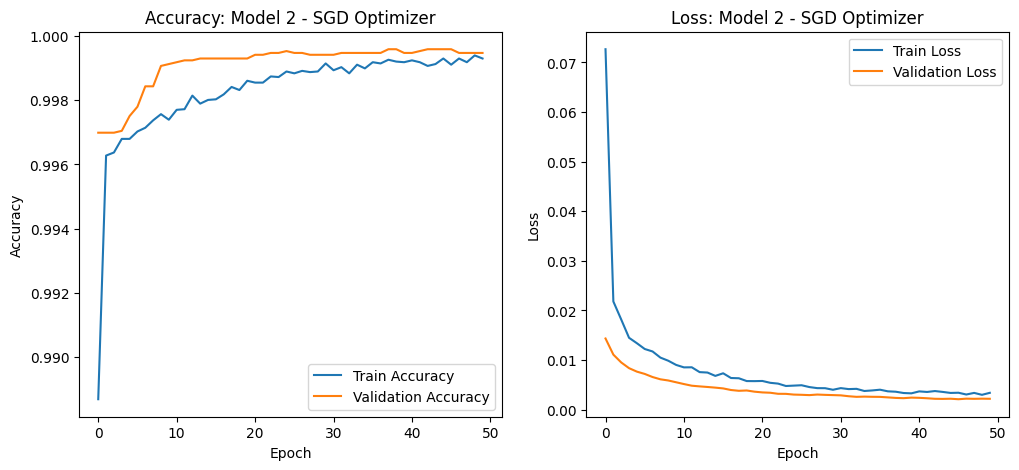

540/540 [==============================] - 1s 2ms/step - loss: 0.0022 - accuracy: 0.9995
Base Model Validation Accuracy: 0.9997684955596924
Model 1 Validation Accuracy: 0.9995949268341064
Model 2 Validation Accuracy: 0.9994791746139526


In [8]:
# Extracting metrics for the base model
base_train_acc = history.history['accuracy']
base_val_acc = history.history['val_accuracy']
base_train_loss = history.history['loss']
base_val_loss = history.history['val_loss']

# Extracting metrics for Model 1
model1_train_acc = history1.history['accuracy']
model1_val_acc = history1.history['val_accuracy']
model1_train_loss = history1.history['loss']
model1_val_loss = history1.history['val_loss']

# Extracting metrics for Model 2
model2_train_acc = history2.history['accuracy']
model2_val_acc = history2.history['val_accuracy']
model2_train_loss = history2.history['loss']
model2_val_loss = history2.history['val_loss']

import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_metrics(train_acc, val_acc, train_loss, val_loss, model_label):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy: {model_label}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss: {model_label}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plotting for each model
plot_metrics(base_train_acc, base_val_acc, base_train_loss, base_val_loss, 'Base Model')
plot_metrics(model1_train_acc, model1_val_acc, model1_train_loss, model1_val_loss, 'Model 1 - More Layers')
plot_metrics(model2_train_acc, model2_val_acc, model2_train_loss, model2_val_loss, 'Model 2 - SGD Optimizer')


# Assuming you have validation data X_val, y_val
base_val_score = model.evaluate(X_val, y_val)
model1_val_score = model1.evaluate(X_val, y_val)
model2_val_score = model2.evaluate(X_val, y_val)

print(f"Base Model Validation Accuracy: {base_val_score[1]}")
print(f"Model 1 Validation Accuracy: {model1_val_score[1]}")
print(f"Model 2 Validation Accuracy: {model2_val_score[1]}")